# Face identification

### Inport needed libraries

For clarity, and to avoid problems, firstly include all needed libraries at the begining of the notebook. Import all needed libraries.

In [ ]:
# Import general purpose python libraries
import os
import matplotlib.pyplot as plt
from PIL import Image # For handling the images
import numpy as np

# Import different Keras functionalities
import tensorflow as tf
from keras.applications import VGG16, ResNet50
from keras.optimizers import Adam
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Add, ReLU, Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import concatenate
from keras.constraints import max_norm
# from keras.layers.convolutional import Conv2D
# from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from keras.utils import np_utils
from keras.models import Model
from keras.models import load_model


In [ ]:
# Import function to plot the confussion matrix
import plotcm

### Configuration parameters
Configuration values of different parts of the solution. You should change some of them to obtain better results.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving MIT-CBCL.zip to MIT-CBCL.zip


In [ ]:
import zipfile
import io
zip_file = 'MIT-CBCL.zip'

# Extraer el contenido del ZIP
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file]), 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
# Randomize the initial network weights
random_seed = True

# Paths to where training, testing, and validation images are
database_dir = './MIT-CBCL'
train_dir = './MIT-CBCL/train'
val_dir = './MIT-CBCL/val'
test_dir = './MIT-CBCL/test'

# Directory where to store weights of the model and results


# Output dimension (number of sublects in our problem)
num_classes = 10

# Name of each gesture of the database
CLASSES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Parameters that characterize the images
img_height = 150
img_width = 150
img_channels = 1 # although some images could be rgb, we work with grayscale images
color_mode = 'grayscale'

### Database samples

The face database is in folder "MIT-CBCL". Database images are split into "train", "test", and "val", folders. Each of those three folders is composed of 10 different folders, each of those folders contains images of each subject. Images do not have the same size but most of them are close to 150x150 pixels. With the next lines you can see a sample image of each subject in the training folder.

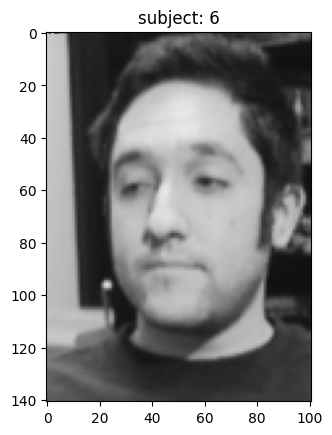

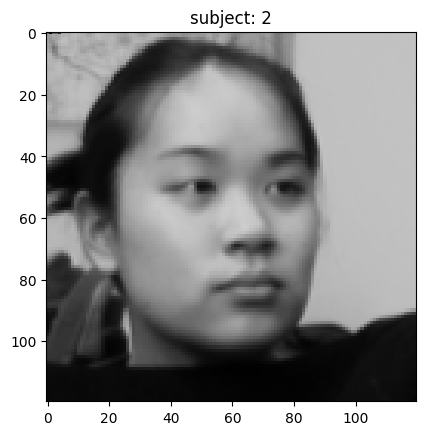

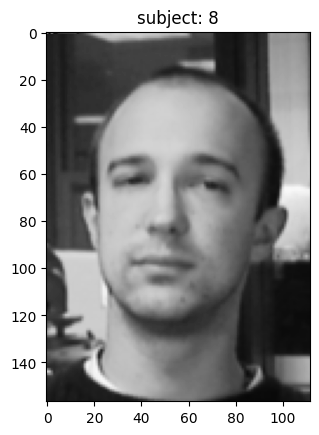

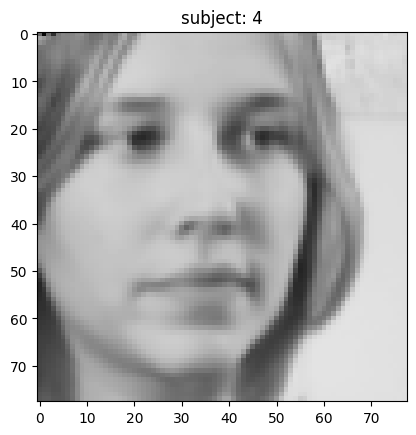

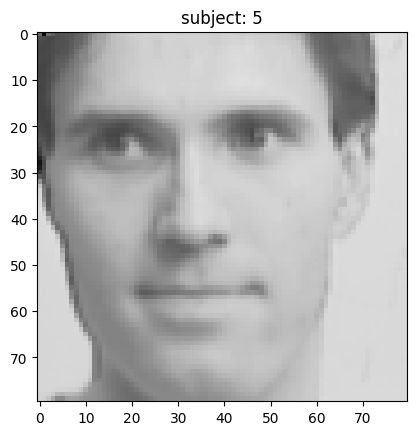

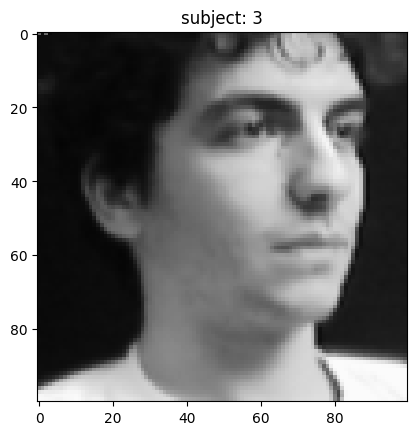

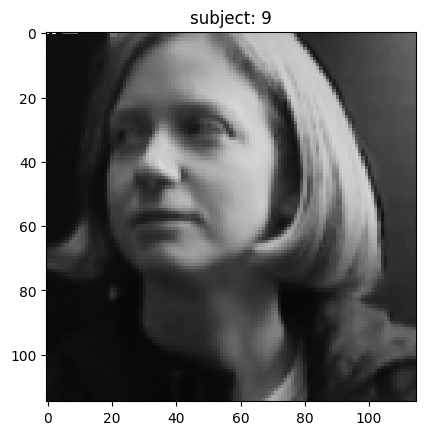

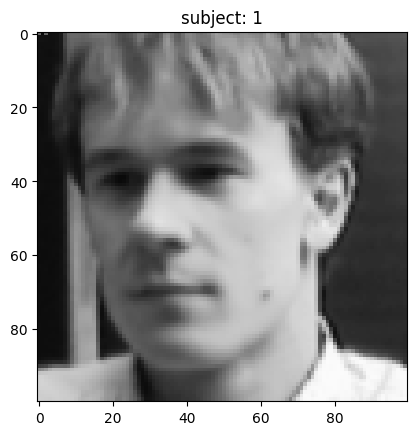

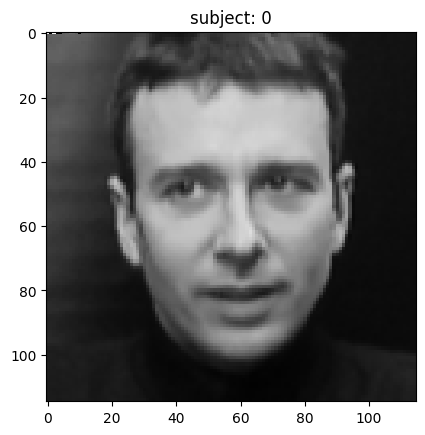

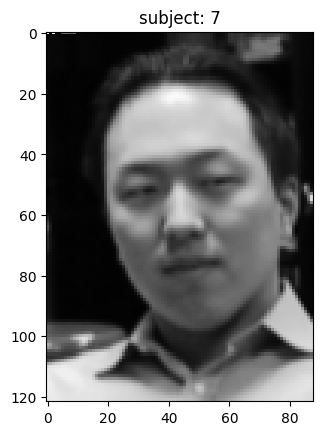

In [ ]:
path_subjects = "./MIT-CBCL/train"
for i in os.listdir(path_subjects):
    count = 0
    for j in os.listdir(path_subjects + '/' + str(i)):
        if count==0:
            count = 1
            img = Image.open(path_subjects + '/' + str(i) + '/' + str(j))
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            plt.title('subject: ' + str(i))
            plt.show()

# Training process

## Create the model
Copy VGG16 from L4 and ResNet50 from Keras library.

In [ ]:
# global model
def create_model(input_shape):

    # dropout = 0.5

    # # CNN architecture
    # input_image = Input(shape=(img_height, img_width, 3))
    # x1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input_image)
    # x1 = Conv2D(64, (3, 3), padding='same', activation='relu')(x1)
    # x1 = MaxPooling2D((2, 2))(x1)

    # x1 = Conv2D(128, (3, 3), padding='same', activation='relu')(x1)
    # x1 = Conv2D(128, (3, 3), padding='same', activation='relu')(x1)
    # x1 = MaxPooling2D((2, 2))(x1)

    # x1 = Conv2D(256, (3, 3), padding='same', activation='relu')(x1)
    # x1 = Conv2D(256, (3, 3), padding='same', activation='relu')(x1)
    # x1 = Conv2D(256, (1, 1), padding='same', activation='relu')(x1)
    # x1 = MaxPooling2D((2, 2))(x1)

    # x1 = Conv2D(512, (3, 3), padding='same', activation='relu')(x1)
    # x1 = Conv2D(512, (3, 3), padding='same', activation='relu')(x1)
    # x1 = Conv2D(512, (1, 1), padding='same', activation='relu')(x1)
    # x1 = MaxPooling2D((2, 2))(x1)

    # x1 = Conv2D(512, (3, 3), padding='same', activation='relu')(x1)
    # x1 = Conv2D(512, (3, 3), padding='same', activation='relu')(x1)
    # x1 = Conv2D(512, (1, 1), padding='same', activation='relu')(x1)
    # x1 = MaxPooling2D((2, 2))(x1)

    # x1 = Flatten()(x1)

    # x = Dense(4096, activation='relu', kernel_constraint=max_norm(3))(x1)
    # x = Dropout(dropout)(x)
    # x = Dense(4096, activation='relu', kernel_constraint=max_norm(3))(x)
    # x = Dropout(dropout)(x)

    # out = Dense(num_classes, activation='softmax')(x)


    model = ResNet50(include_top=True, weights=None, input_tensor=None,
                    input_shape=input_shape, classes=num_classes
                    )
    # Print the architecture of the model
    model.summary()

    return model

### Set model training process
Configuration of several training decisions:
1. Optimizer using `Adam`
2. Model training configuration using `compile`. Use a loss and a metric function appropriate for the task
3. Creation of the data generator for the training dataset using `image_dataset_from_directory`
4. Creation of the data generator for the validation dataset using `image_dataset_from_directory`

In [ ]:
# Set random seed
if random_seed:
    seed = np.random.randint(0,2*31-1)
else:
    seed = 5

np.random.seed(seed)
tf.random.set_seed(seed)

# Parameters that configures the training process
# batch_size = 20 # Batch size
# epochs = 20 # Number of epochs. Set to 20 for this work
# initial_lr = 1e-2 # Learning rate


# Training function
def train_fun(lr, batch_size, epochs, experiment_rootdir, weights_path, img_height, img_width, img_channels):
  # global model
  model = create_model((img_height, img_width, img_channels))

  # 1. Configure optimizer
  optimizer = Adam(learning_rate=lr)

  # 2. Configure training process
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

  # 3. Generate train dataset (ds) from directory of samples
  train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    shuffle=True,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale')

  # 4. Generate validation dataset (ds) from directory of samples
  val_ds  = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    shuffle=True,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale')


  weights_load_path = os.path.join(experiment_rootdir, weights_path)
  if weights_load_path:
      try:
          model.load_weights(weights_load_path)
          print("Loaded model from {}".format(weights_load_path))
      except:
          print("Impossible to find weight path. Returning untrained model")

  # Fit the model
  history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

  # 1. Plot accuracy
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('Accuracy for batch size '+str(batch_size)+' with learning rate '+str(lr))
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  fig_save_path = os.path.join(experiment_rootdir, "accuracy_"+str(batch_size)+"_"+str(lr)+".png")
  plt.savefig(fig_save_path)
  plt.show()

  #2. Plot loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss for batch size '+str(batch_size)+' with learning rate '+str(lr))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  fig_save_path = os.path.join(experiment_rootdir, "loss_"+str(batch_size)+"_"+str(lr)+".png")
  plt.savefig(fig_save_path)
  plt.show()


  test_ds  = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    shuffle=False,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale')


  # Evaluate model
  scores = model.evaluate(test_ds, verbose=0)
 # print("Accuracy: %.2f%%" % (scores[1]*100))
  print(f"Learning Rate: {lr}, Batch Size: {batch_size}, Accuracy: {(scores[1]*100)}%")


  predictions = model.predict(test_ds, batch_size=None)
  y_pred = tf.argmax( predictions,axis=-1)
  y_true = tf.argmax(tf.concat([label for image, label in test_ds], axis=0), axis=1)
  confussion_matrix = plotcm.plotcm(experiment_rootdir, y_true, y_pred,CLASSES, experiment_rootdir, normalize=True)


### Train the model

Training with batch size 20 and learning rate 0.01
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 1)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 1)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                    

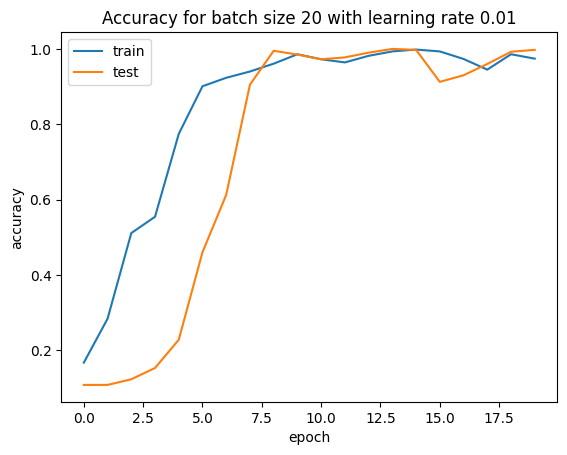

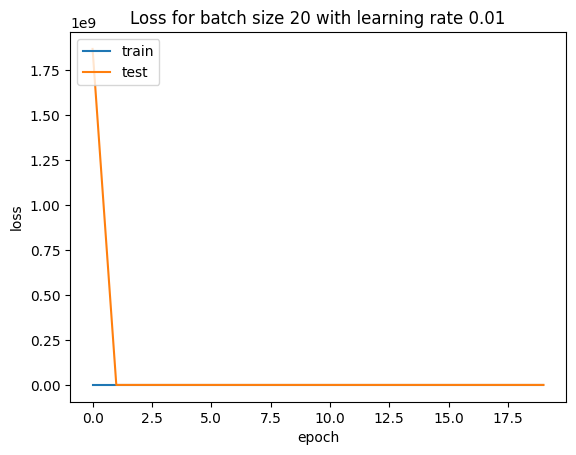

Found 400 files belonging to 10 classes.
Learning Rate: 0.01, Batch Size: 20, Accuracy: 98.50000143051147%
20/20 [==============================] - 2s 32ms/step


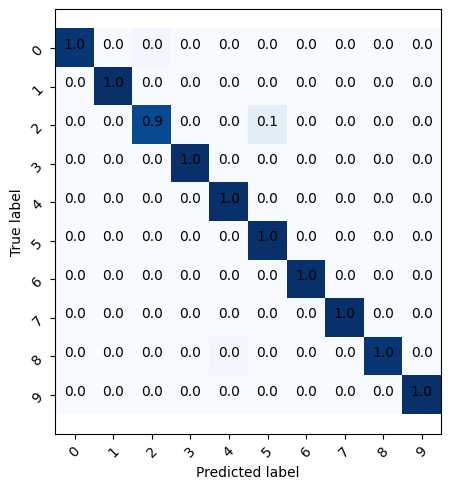

Training with batch size 20 and learning rate 0.0001
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 1)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 1)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                  

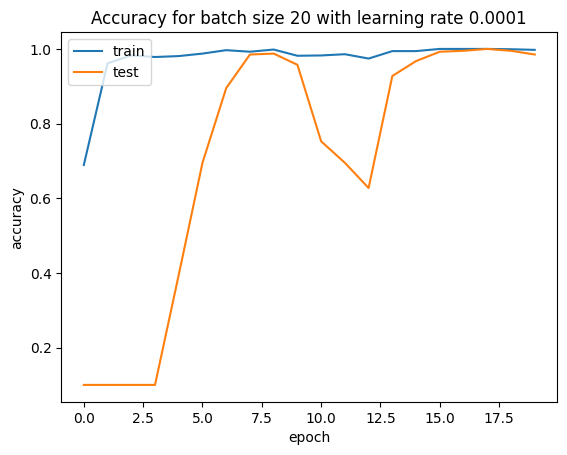

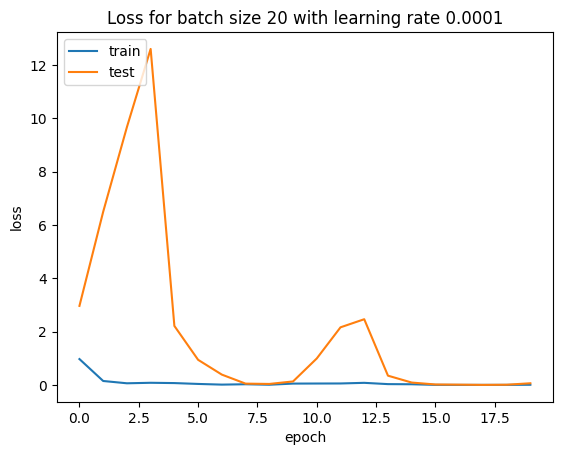

Found 400 files belonging to 10 classes.
Learning Rate: 0.0001, Batch Size: 20, Accuracy: 99.00000095367432%
20/20 [==============================] - 2s 32ms/step


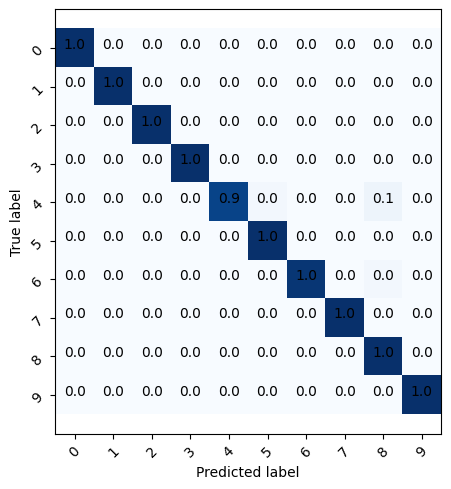

Training with batch size 20 and learning rate 1e-06
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 1)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 1)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                   

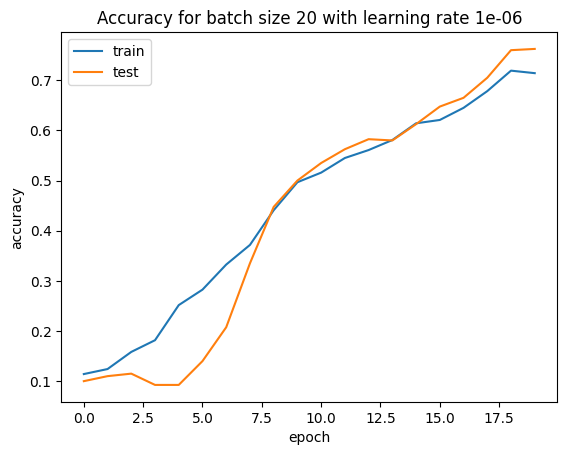

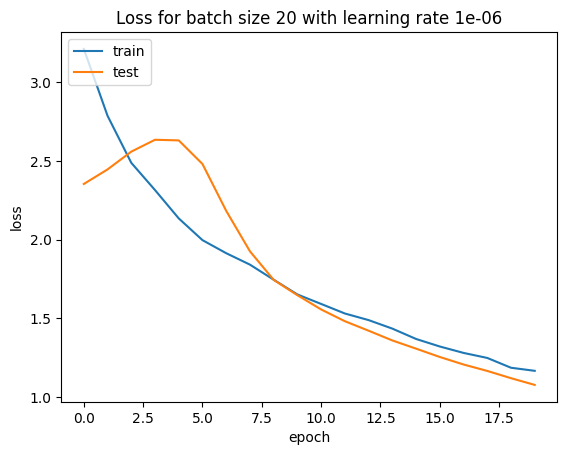

Found 400 files belonging to 10 classes.
Learning Rate: 1e-06, Batch Size: 20, Accuracy: 76.49999856948853%
20/20 [==============================] - 2s 32ms/step


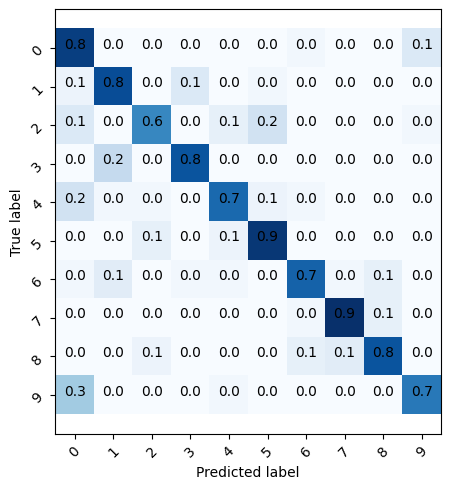

Training with batch size 20 and learning rate 1e-08
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 1)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 1)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                   

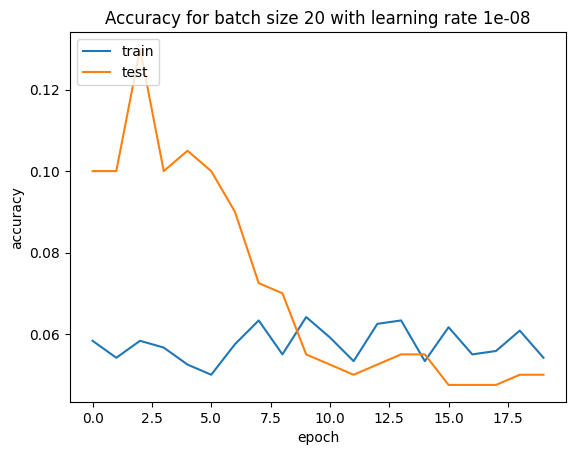

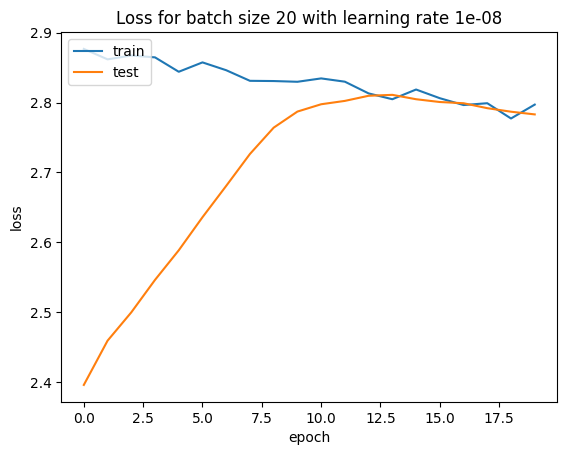

Found 400 files belonging to 10 classes.
Learning Rate: 1e-08, Batch Size: 20, Accuracy: 5.249999836087227%
20/20 [==============================] - 1s 32ms/step


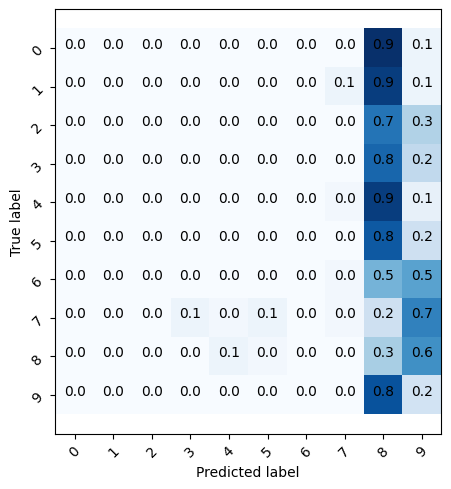

In [ ]:
lr_list = [1e-2, 1e-4, 1e-6, 1e-8]
# lr = 1e-5
batch_size = 20
# batch_size_list = [1, 5, 20, 50]
epochs = 20

# for batch_size in batch_size_list:
for lr in lr_list:

  experiment_rootdir = "./test/" + str(batch_size)+"_"+ str(lr)+"/"
  # Create experiment directory if it does not exists
  if not os.path.exists(experiment_rootdir):
      os.makedirs(experiment_rootdir)

  weights_path = "weights_"+ str(batch_size)+"_"+ str(lr)+".h5" # Name of the file to store the weights

  print("Training with batch size "+str(batch_size)+" and learning rate "+str(lr))
  input_img = (img_width, img_height, 1)
  train_fun(lr, batch_size, epochs, experiment_rootdir, weights_path, img_height=img_height, img_width=img_width, img_channels=img_channels)

In [ ]:
!zip -r /content/resnet_lr_test.zip /content/test

  adding: content/test/ (stored 0%)
  adding: content/test/20_1e-08/ (stored 0%)
  adding: content/test/20_1e-08/accuracy_20_1e-08.png (deflated 7%)
  adding: content/test/20_1e-08/loss_20_1e-08.png (deflated 8%)
  adding: content/test/20_1e-08/CM.png (deflated 17%)
  adding: content/test/20_1e-06/ (stored 0%)
  adding: content/test/20_1e-06/accuracy_20_1e-06.png (deflated 7%)
  adding: content/test/20_1e-06/loss_20_1e-06.png (deflated 8%)
  adding: content/test/20_1e-06/CM.png (deflated 17%)
  adding: content/test/20_0.0001/ (stored 0%)
  adding: content/test/20_0.0001/accuracy_20_0.0001.png (deflated 8%)
  adding: content/test/20_0.0001/loss_20_0.0001.png (deflated 8%)
  adding: content/test/20_0.0001/CM.png (deflated 23%)
  adding: content/test/20_0.01/ (stored 0%)
  adding: content/test/20_0.01/accuracy_20_0.01.png (deflated 7%)
  adding: content/test/20_0.01/loss_20_0.01.png (deflated 14%)
  adding: content/test/20_0.01/CM.png (deflated 21%)
